# Chapter 6 Applied Exercises Linear model selection and regularisation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML

### 8. In this exercise, we will generate simulated data, and will then use this data to perform forward and backward stepwise selection.

#### (a) Create a random number generator and use its normal() method to generate a predictor X of length n = 100, as well as a noise vector $\epsilon$ of length n = 100.

In [7]:
np.random.seed(1)
x = np.random.normal(0,1,100)
epsilon = np.random.normal(0,1,100)
X = x

#### (b) Generate a response vector $Y$ of length n = 100 according to the model

#### $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$

#### where $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ are constants of your choice.

In [218]:
beta = [2,2,3,2.5]
y_calc = beta[0] + beta[1]*x + beta[2]*(x**2) + beta[3]*(x**3) + epsilon

Text(0, 0.5, 'y-axis')

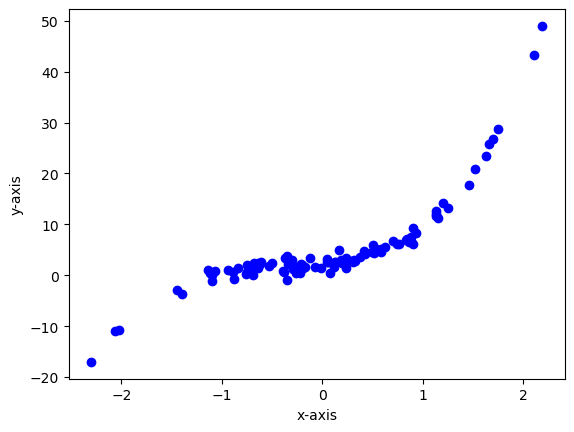

In [219]:
fig, ax = plt.subplots()
ax.plot(x,y_calc, 'bo')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')

#### (c) Use forward stepwise selection in order to select a model containing the predictors $X, X^2, X^3,...,$ $X$<sup>10</sup> What is the model obtained according to $C_p$? Report the coefficients of the model obtained.

In [220]:
# Lets first make a dataframe that contains the X and y variables
# It is necessary to make a dataframe of all predictors so that we an pass it to statsmodels or some similar function
X = pd.DataFrame({'X': x,
                    'X2': x**2,
                    'X3': x**3,
                    'X4': x**4,
                    'X5': x**5,
                    'X6': x**6,
                    'X7': x**7,
                    'X8': x**8,
                    'X9': x**9,
                    'X10': x**10})
y = pd.DataFrame({'y': y_calc})
print(list(X.columns))

['X', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']


#### I need a way to add predictors one by one so that I can pass it to the statsmodels function. 

In [221]:
formulas_list = []
y_name = y.columns[0]

for i in range(1,X.shape[1]+1):
    X_smf = ' + '.join(X.columns[0:i])
    formula = '{} ~ {}'.format(y_name,X_smf)
    print(formula)
    formulas_list.append(formula)

len(formulas_list)

y ~ X
y ~ X + X2
y ~ X + X2 + X3
y ~ X + X2 + X3 + X4
y ~ X + X2 + X3 + X4 + X5
y ~ X + X2 + X3 + X4 + X5 + X6
y ~ X + X2 + X3 + X4 + X5 + X6 + X7
y ~ X + X2 + X3 + X4 + X5 + X6 + X7 + X8
y ~ X + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9
y ~ X + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10


10

In [222]:
# Define a function which returns the formula to be passed to the statsmodel function
def ols_formula(df, dependent_var, *excluded_cols):
    """Returns a formula in the form y ~ x1 + x2 +...+ xp that can be passed to the statsmodel function"""

    df_columns = list(df.columns)
    df_columns.remove(dependent_var)
    for col in excluded_cols:
        df_columns.remove(col)
    return dependent_var + ' ~ ' + ' + '.join(df_columns)

ols_formula(pd.concat([y,X]),'y')

'y ~ X + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10'

In [252]:
def forward_stepwise(X, y):
    """
    Perform forward stepwise selection of all possible combinations of predictors and return all the metrics
    
    X: Dataframe with the predictors

    y: Dataframe with the response variable

    """

    # Get the y-predictor name
    y_name = y.columns[0] # Get all the column names and take the first one. 

    # Start first predictor and add predictors in a forward stepwise manner. Store the result in a list
    formulas_list = []
    for i in range(1,X.shape[1]+1):
        X_smf = ' + '.join(X.columns[0:i])
        formula = '{} ~ {}'.format(y_name,X_smf)
        formulas_list.append(formula)


    # Loop throug all the models and fit
    adjr2_list = []
    bic_list = []
    aic_list = []
    params_list = []
    for i in range(len(formulas_list)):
        model = smf.ols(formula=formulas_list[i], data=pd.concat([X,y], axis=1)).fit()

        # Make predictions
        y_pred = model.predict(X)

        # Get the adjusted R-squared, BIC, and AIC metrics. 
        adjr2 = round(model.rsquared_adj,5)
        bic = round(model.bic,5)
        aic = round(model.aic,5)
        params = round(model.params,5)
        
        adjr2_list.append(adjr2)
        bic_list.append(bic)
        aic_list.append(aic)
        params_list.append(params)

    # Add everything into a dataframe
    # Columns
    result_dict = {'Model' : formulas_list,
                'Adjusted R-squared' : adjr2_list,
                'BIC' : bic_list,
                'AIC' : aic_list}

    results = pd.DataFrame(result_dict, index=np.arange(X.shape[1]))
    return (results, params_list)

In [253]:
fwd_step_result = forward_stepwise(X,y)[0]
fwd_step_result

,Model,Adjusted R-squared,BIC,AIC
0,y ~ X,0.69217,610.48633,605.27599
1,y ~ X + X2,0.80718,567.28663,559.47112
2,y ~ X + X2 + X3,0.98886,285.73456,275.31388
3,y ~ X + X2 + X3 + X4,0.98940,284.27639,271.25054
4,y ~ X + X2 + X3 + X4 + X5,0.98929,288.88155,273.25053
5,y ~ X + X2 + X3 + X4 + X5 + X6,0.98919,293.41095,275.17475
6,y ~ X + X2 + X3 + X4 + X5 + X6 + X7,0.98907,298.01263,277.17127
7,y ~ X + X2 + X3 + X4 + X5 + X6 + X7 + X8,0.98913,300.98557,277.53904
8,y ~ X + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,0.98923,303.50967,277.45797
9,y ~ X + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 ...,0.98916,307.65418,278.99731


#### For the forward stepwise algorithm, the model with the highest adjusted $R^2$ value is:

In [247]:
fwd_step_result['Model'].iloc[np.argmax(fwd_step_result['Adjusted R-squared'])]

'y ~ X + X2 + X3 + X4'

#### For the forward stepwise algorithm, the model with the lowest BIC value is:

In [248]:
fwd_step_result['Model'].iloc[np.argmin(fwd_step_result['BIC'])]

'y ~ X + X2 + X3 + X4'

#### For the forward stepwise algorithm, the model with the lowest AIC value is:

In [303]:
fwd_step_result['Model'].iloc[np.argmin(fwd_step_result['AIC'])]

'y ~ X + X2 + X3 + X4'

#### The coefficients for this model are:

In [250]:
forward_stepwise(X,y)[1][np.argmin(fwd_step_result['AIC'])]

Intercept    2.31398
X            1.91273
X2           2.45552
X3           2.59918
X4           0.13936
dtype: float64

#### Recall that the actual coefficients were chosen as:

In [251]:
beta

[2, 2, 3, 2.5]

We can see that the models with the highest $R^2$, lowest BIC and AIC all include an additional term $X^4$, which is an unnessary predictor. The coefficients are relatively accurately predicted. It would be interesting to see if the best subset selection method yields more accurate results. 

#### (d) Repeat (c), using backwards stepwise selection. How does your answer compare to the results in (c)?

In [280]:
for i in range(X.shape[1]+1,0,-1):
    X_smf = ' + '.join(X.columns[0:i])
    formula = '{} ~ {}'.format(y_name,X_smf)
    print(formula)

y ~ X + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10
y ~ X + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10
y ~ X + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9
y ~ X + X2 + X3 + X4 + X5 + X6 + X7 + X8
y ~ X + X2 + X3 + X4 + X5 + X6 + X7
y ~ X + X2 + X3 + X4 + X5 + X6
y ~ X + X2 + X3 + X4 + X5
y ~ X + X2 + X3 + X4
y ~ X + X2 + X3
y ~ X + X2
y ~ X


In [299]:
def backward_stepwise(X, y):
    """
    Perform backward stepwise selection of all possible combinations of predictors and return all the metrics
    
    X: Dataframe with the predictors

    y: Dataframe with the response variable

    """

    # Get the y-predictor name
    y_name = y.columns[0] # Get all the column names and take the first one. 

    # Start with all the predictors and remove predictors in a backward stepwise manner. Store the result in a list
    formulas_list = []
    for i in range(X.shape[1],0,-1):
        X_smf = ' + '.join(X.columns[0:i])
        formula = '{} ~ {}'.format(y_name,X_smf)
        formulas_list.append(formula)
    
    # Loop throug all the models and fit
    adjr2_list = []
    bic_list = []
    aic_list = []
    params_list = []
    for i in range(len(formulas_list)):
        model = smf.ols(formula=formulas_list[i], data=pd.concat([X,y], axis=1)).fit()

        # Make predictions
        y_pred = model.predict(X)

        # Get the adjusted R-squared, BIC, and AIC metrics. 
        adjr2 = round(model.rsquared_adj,5)
        bic = round(model.bic,5)
        aic = round(model.aic,5)
        params = round(model.params,5)
        
        adjr2_list.append(adjr2)
        bic_list.append(bic)
        aic_list.append(aic)
        params_list.append(params)

    # Add everything into a dataframe
    # Columns
    result_dict = {'Model' : formulas_list,
                'Adjusted R-squared' : adjr2_list,
                'BIC' : bic_list,
                'AIC' : aic_list}

    results = pd.DataFrame(result_dict, index=np.arange(X.shape[1]))
    return (results, params_list)

In [300]:
back_step_result = backward_stepwise(X,y)[0]
back_step_result

,Model,Adjusted R-squared,BIC,AIC
0,y ~ X + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 ...,0.98916,307.65418,278.99731
1,y ~ X + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9,0.98923,303.50967,277.45797
2,y ~ X + X2 + X3 + X4 + X5 + X6 + X7 + X8,0.98913,300.98557,277.53904
3,y ~ X + X2 + X3 + X4 + X5 + X6 + X7,0.98907,298.01263,277.17127
4,y ~ X + X2 + X3 + X4 + X5 + X6,0.98919,293.41095,275.17475
5,y ~ X + X2 + X3 + X4 + X5,0.98929,288.88155,273.25053
6,y ~ X + X2 + X3 + X4,0.98940,284.27639,271.25054
7,y ~ X + X2 + X3,0.98886,285.73456,275.31388
8,y ~ X + X2,0.80718,567.28663,559.47112
9,y ~ X,0.69217,610.48633,605.27599


#### For the backward stepwise algorithm, the model with the highest adjusted $R^2$ value is:

In [301]:
back_step_result['Model'].iloc[np.argmax(fwd_step_result['Adjusted R-squared'])]

'y ~ X + X2 + X3 + X4 + X5 + X6 + X7'

#### For the backward stepwise algorithm, the model with the lowest BIC value is:

In [302]:
back_step_result['Model'].iloc[np.argmin(back_step_result['BIC'])]

'y ~ X + X2 + X3 + X4'

#### For the forward stepwise algorithm, the model with the lowest AIC value is:

In [304]:
back_step_result['Model'].iloc[np.argmin(back_step_result['AIC'])]

'y ~ X + X2 + X3 + X4'

#### The coefficients for this model are:

In [306]:
backward_stepwise(X,y)[1][np.argmin(back_step_result['AIC'])]

Intercept    2.31398
X            1.91273
X2           2.45552
X3           2.59918
X4           0.13936
dtype: float64

Very similar results compared to forward stepwise, except for the $R^2$ method. I'm not quite sure why. The coefficients are also similar. 

### (e) Now fit a lasso model to the simulated data, again using $X, X^2, X^3,...,$ $X$<sup>10</sup> as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coeicient estimates, and discuss the results obtained.